## Combined Instantaneous and Time-Lagged Causality

The final step of the project is combining instantaneous causal discovery (with CD-NOD, an extension of PC for nonstationary data) with time-lagged causal discovery (Granger causality with a deep recurrent neural network). This is important because our variables might influence each other during the same time step, since each data point is averaged over a month which is more than enough time for the system to change. Being able to discover causality at any time delay is the end goal of this project.

In [1]:
# import sys
# import os
import torch

# from torch import nn, optim
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

from dataset import EarthSystemsDataset
from nn_util import GrangerRNN
from rnn import rnn_layers4

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def get_residuals(model_path, num_models, data, lags):
    '''
    Get the residuals (y_hat - y) for a given model
    '''
    model = GrangerRNN(rnn_layers4, num_models, len(data.data.columns), lags=lags, reg_lags=False, last_only=True).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    with torch.no_grad():
        pred_loader = DataLoader(data, batch_size=32, shuffle=False)
        all_pred = torch.cat([model(X.to(device, dtype=torch.float))-y for X, y in pred_loader], dim=0)
        all_pred = torch.cat([torch.zeros(lags, num_models), all_pred], dim=0)

        
    return all_pred

def get_all_residuals(model_paths, lags):
    '''
    Get ALL residuals for a set of models. Will be returned as a Tensor of shape (num_models, num_datapoints, num_features)
    '''
    data_var_names = ['global_temp', 'petroleum', 'elec_fossil', 'elec_clean', 'co2', 'ch4']
    y_vals = ['temp_change', 'petroleum', 'elec_fossil', 'elec_clean', 'co2_average', 'ch4_average']

    data = EarthSystemsDataset(data_var_names, y_vals=y_vals, add_index=True, val_frac=0.03, lags=lags, mode='rnn', normalize=True)
    data.train_mode()

    all_res = []
    for model_path in model_paths:
        all_res.append(get_residuals(model_path, len(y_vals), data, lags))
    
    return torch.stack(all_res)
        

        

In [4]:
lags = 30
model_paths = [f'models/rnn_granger{i}.pth' for i in range(30)]
all_res = get_all_residuals(model_paths, lags)

In [5]:
# Calculate the mean residuals to get a more stable outcome
mean_res = all_res.mean(dim=0)

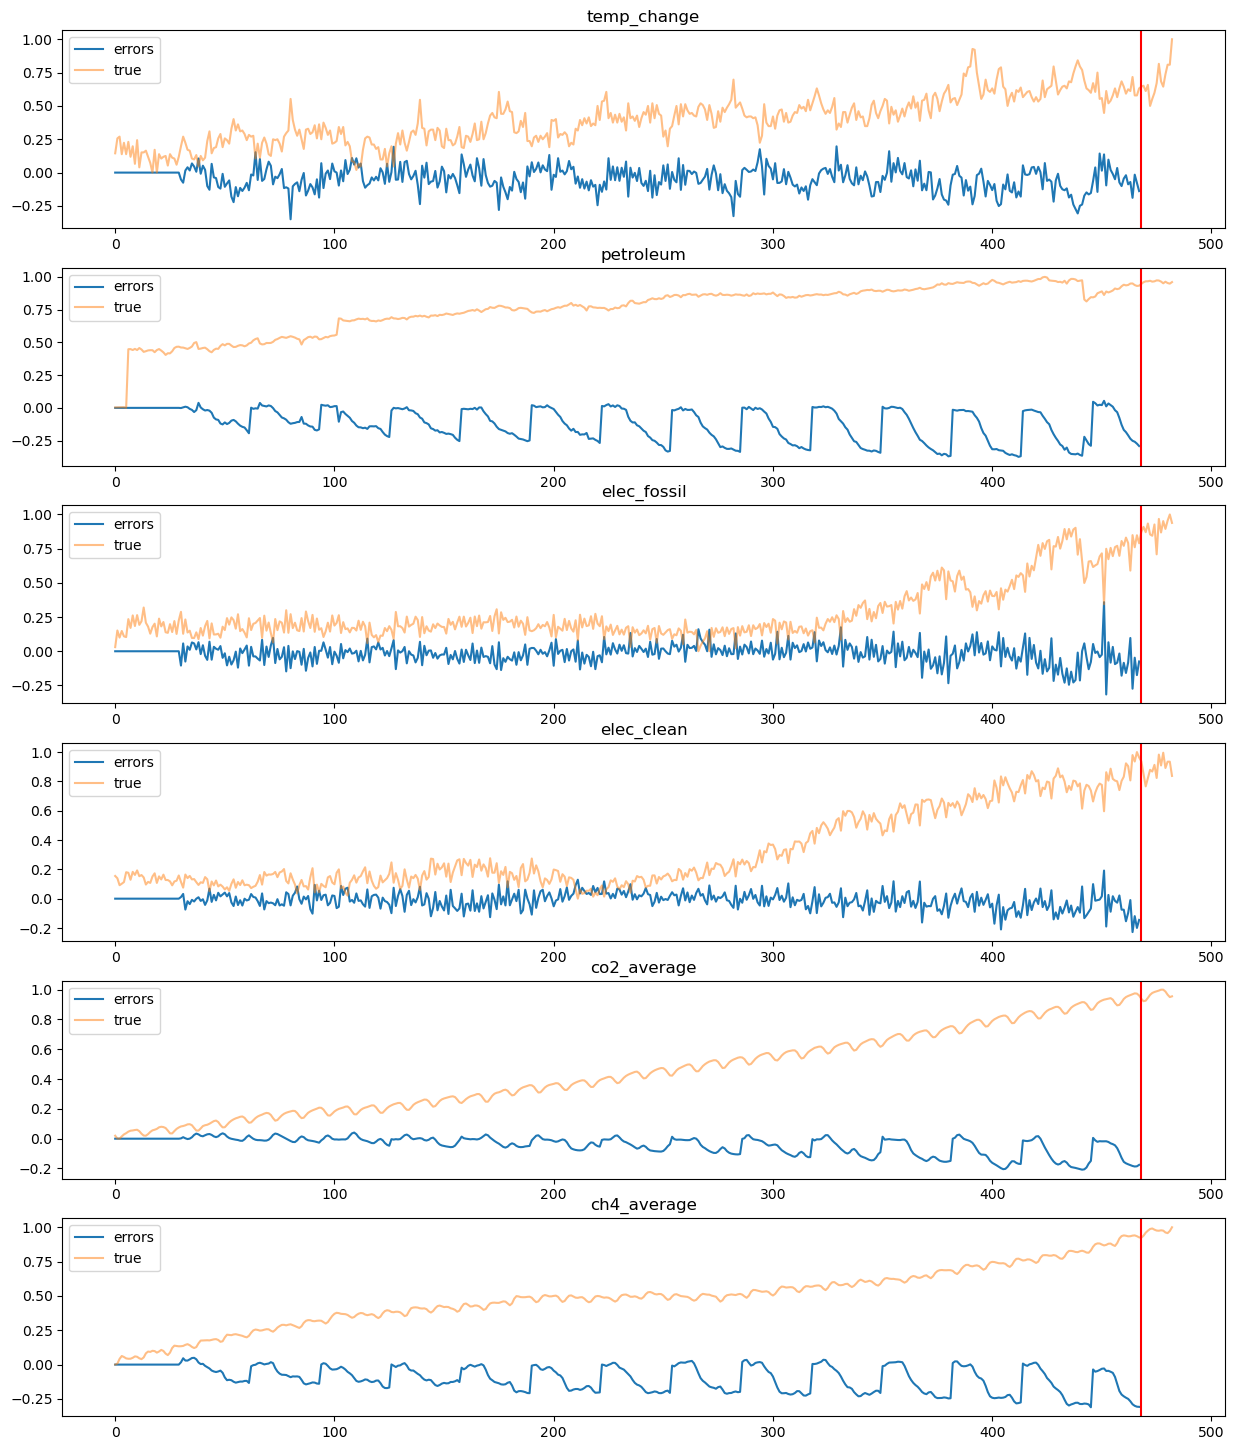

In [6]:
# Plotting the mean residuals for each variable
data_var_names = ['global_temp', 'petroleum', 'elec_fossil', 'elec_clean', 'co2', 'ch4']
y_vals = ['temp_change', 'petroleum', 'elec_fossil', 'elec_clean', 'co2_average', 'ch4_average']

data = EarthSystemsDataset(data_var_names, y_vals=y_vals, add_index=True, val_frac=0.03, lags=lags, mode='rnn', normalize=True)
data.train_mode()

fig, axes = plt.subplots(6, 1, figsize=(15,18))
for i in range(len(axes)):
    axes[i].set_title(data.data.columns[i])
    axes[i].plot(mean_res[:,i].tolist(), label='mean residuals')
    axes[i].plot(data.full_data.reset_index()[y_vals[i]], alpha=0.5, label='variable')
    axes[i].axvline(data.train_data.shape[0], color='red')

    axes[i].legend()

In [7]:
# from causallearn.search.ConstraintBased.CDNOD import cdnod
from causallearn.utils.cit import kci
from causallearn.search.ConstraintBased.PC import pc

import numpy as np

In [9]:
cg2 = pc(mean_res.numpy())

  0%|          | 0/6 [00:00<?, ?it/s]

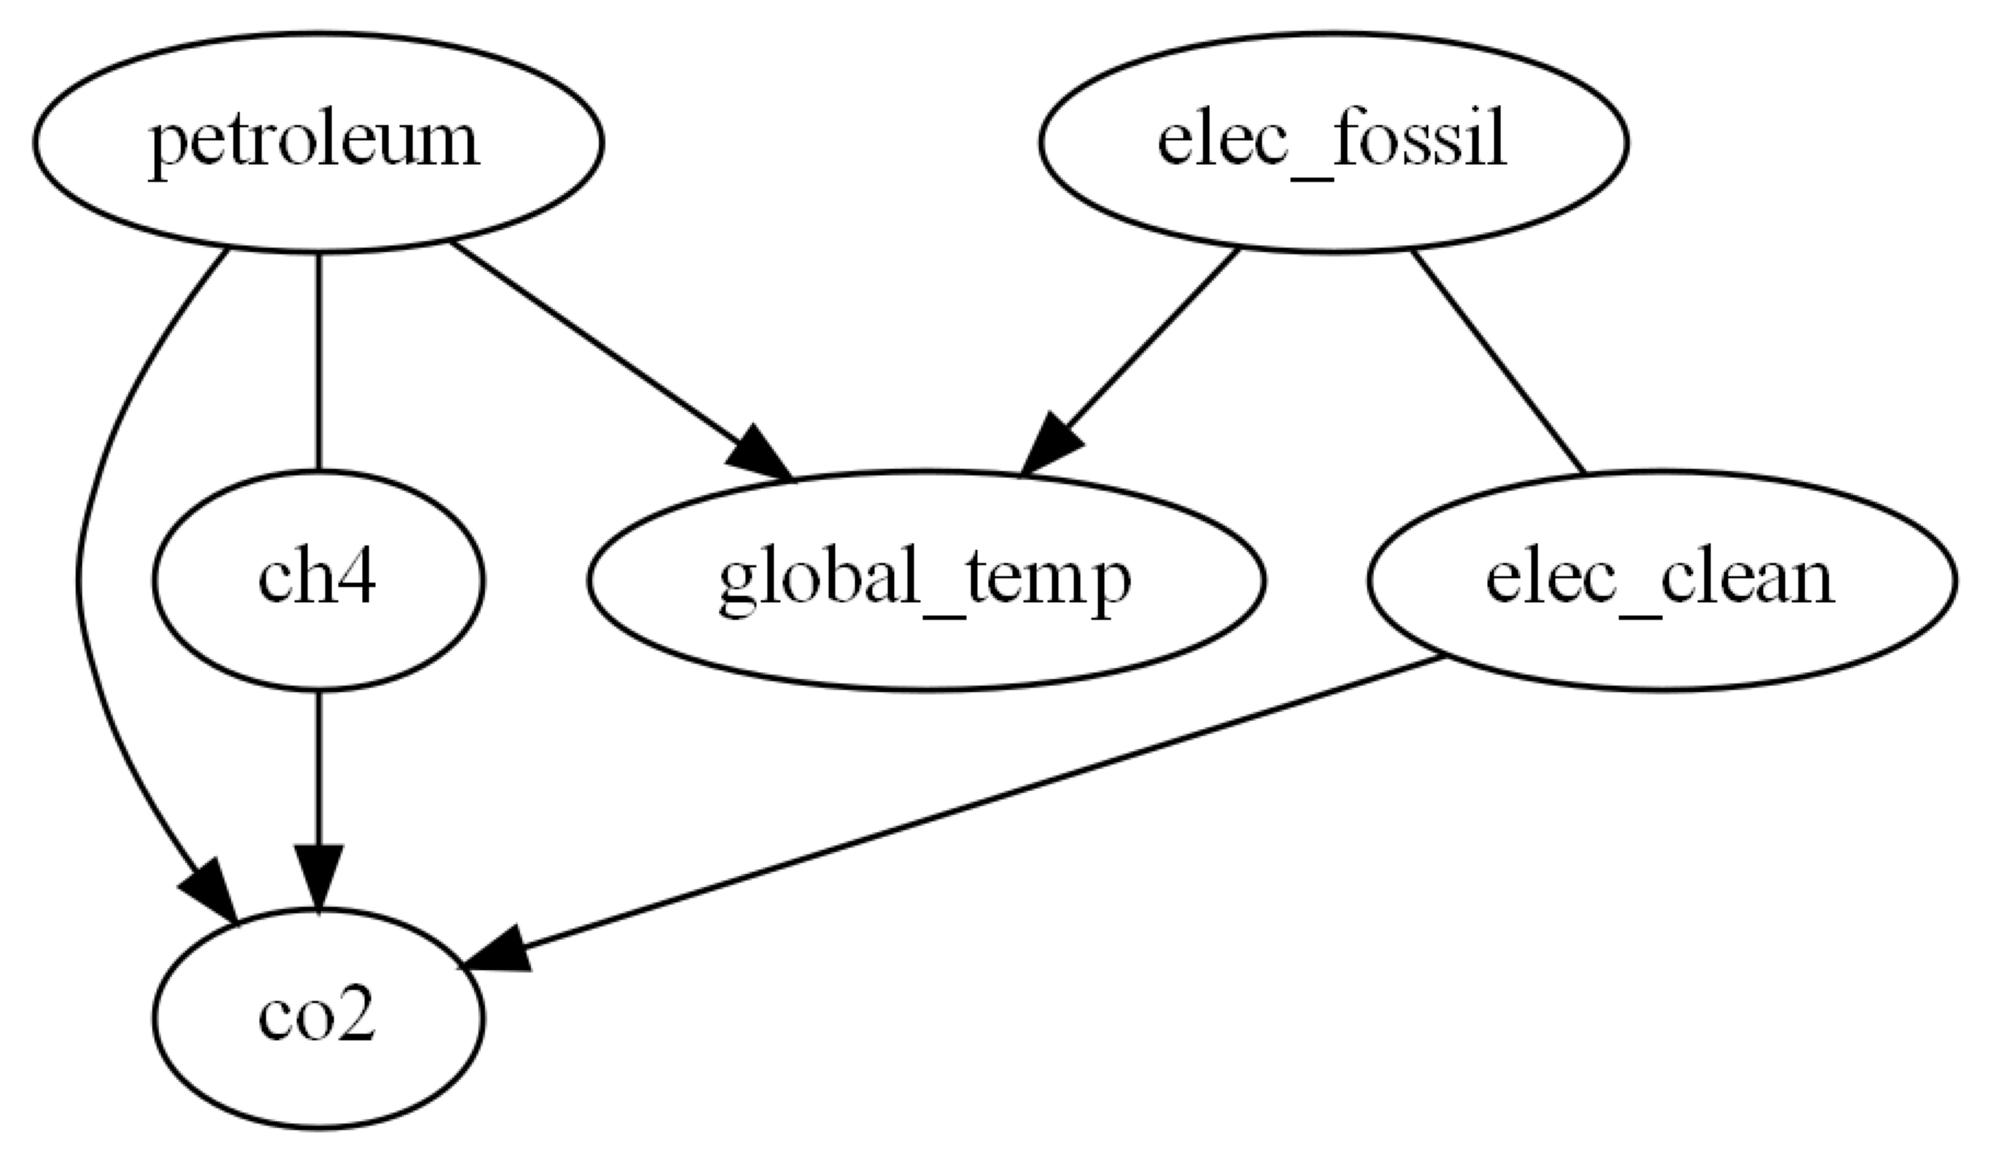

In [10]:
# Visualize instantaneous causal relations of the residuals
cg2.draw_pydot_graph(labels=data_var_names)